In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from sqlalchemy import create_engine, MetaData, Table


In [4]:
# подгружаем .env
load_dotenv()

True

In [5]:
# Считываем все креды
src_host = os.environ.get('DB_SOURCE_HOST')
src_port = os.environ.get('DB_SOURCE_PORT')
src_username = os.environ.get('DB_SOURCE_USER')
src_password = os.environ.get('DB_SOURCE_PASSWORD')
src_db = os.environ.get('DB_SOURCE_NAME') 

dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

s3_bucket = os.environ.get('S3_BUCKET_NAME')
s3_access_key = os.environ.get('AWS_ACCESS_KEY_ID')
s3_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')

telegram_api_key = os.environ.get('TELEGRAM_BOT_API_KEY')

In [6]:
print(telegram_api_key)

7304991854:AAGiGaq5fPFgIWCbvFIaB6GPub2CLy9F4_U


In [7]:
# Создадим соединения
src_conn = create_engine(f'postgresql://{src_username}:{src_password}@{src_host}:{src_port}/{src_db}')
dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')

In [8]:
# Укажем таблицу для удаления
TABLE_NAME = 'buildings'

In [9]:
buildings_data = pd.read_sql(f'select * from {TABLE_NAME}', dst_conn)
buildings_data.head()

,id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,6220,1965,6,55.717113,37.781120,2.64,84,12,True
1,18012,2001,2,55.794849,37.608013,3.00,97,10,True
2,17821,2000,4,55.740040,37.761742,2.70,80,10,True
3,18579,2002,4,55.672016,37.570877,2.64,771,17,True
4,9293,1971,1,55.808807,37.707306,2.60,208,9,True


In [10]:
print(buildings_data.dtypes)

id                     int64
build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator            bool
dtype: object


In [11]:
TABLE_NAME = 'flats'


In [12]:
flats_data = pd.read_sql(f'select * from {TABLE_NAME}', dst_conn)
flats_data.head()

,id,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,building_id
0,0,9,False,9.9,19.900000,1,False,35.099998,9500000,6220
1,1,7,False,0.0,16.600000,1,False,43.000000,13500000,18012
2,2,9,False,9.0,32.000000,2,False,56.000000,13500000,17821
3,3,1,False,10.1,43.099998,3,False,76.000000,20000000,18579
4,4,3,False,3.0,14.000000,1,False,24.000000,5200000,9293


In [13]:
print(flats_data.dtypes)

id                int64
floor             int64
is_apartment       bool
kitchen_area    float64
living_area     float64
rooms             int64
studio             bool
total_area      float64
price             int64
building_id       int64
dtype: object


In [14]:
flats_data.shape

(141362, 10)

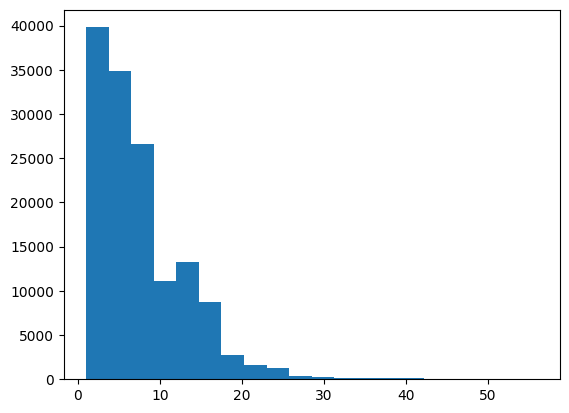

In [15]:
import matplotlib.pyplot as plt

plt.hist(flats_data['floor'], bins=20)
plt.show()

<Axes: xlabel='is_apartment'>

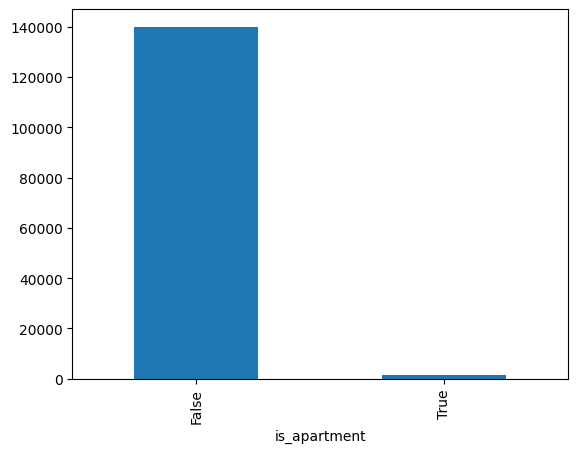

In [16]:
flats_data['is_apartment'].value_counts().plot(kind='bar')

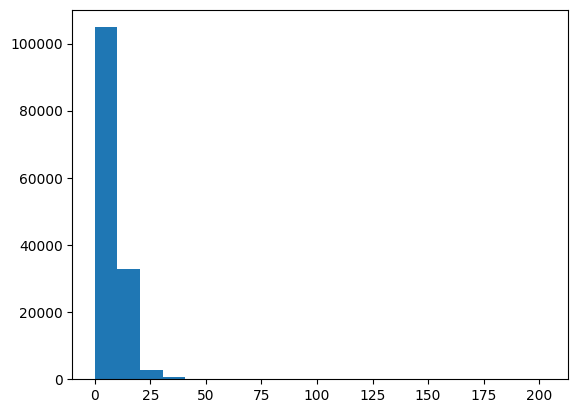

In [17]:
plt.hist(flats_data['kitchen_area'], bins=20)
plt.show()

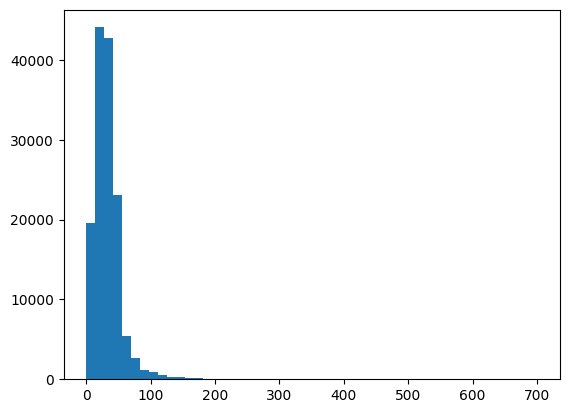

In [18]:
plt.hist(flats_data['living_area'], bins=50)
plt.show()

In [19]:
s1 = '''floor             int64
is_apartment       bool
kitchen_area    float64
living_area     float64
rooms             int64
studio             bool
total_area      float64
price             int64
build_year             int64
building_type_int      int64'''
s2 = '''latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator            bool'''
s1 = s1.split('\n')
s2 = s2.split('\n')
for line in s1:
    line = line.split()
    # if line[1] == 'int64':
    #     print(f"Column('{line[0]}', Integer),")
    # elif line[1] == 'float64':
    #     print(f"Column('{line[0]}', Float),")
    # else:
    #     print(f"Column('{line[0]}', Bool),")
    print(f'f.{line[0]}', end=', ')
for line in s2:
    line = line.split()
    print(f'b.{line[0]}', end=', ')

f.floor, f.is_apartment, f.kitchen_area, f.living_area, f.rooms, f.studio, f.total_area, f.price, f.build_year, f.building_type_int, b.latitude, b.longitude, b.ceiling_height, b.flats_count, b.floors_total, b.has_elevator, 

In [20]:
data = flats_data.merge(buildings_data, 'right', left_on='building_id', right_on='id')
subset = data.columns.drop('id_x').tolist()
is_duplicated_features = data.duplicated(subset=subset, keep=False)
duplicated_data = data[is_duplicated_features]
duplicates_count = duplicated_data[subset].value_counts()
duplicates_count

floor  is_apartment  kitchen_area  living_area  rooms  studio  total_area  price     building_id  id_y   build_year  building_type_int  latitude   longitude  ceiling_height  flats_count  floors_total  has_elevator
6      False         10.000000     30.000000    2      False   45.000000   30000000  3729         3729   1961        1                  55.776543  37.635555  2.70            127          8             True            10
19     False         10.000000     22.000000    2      False   56.700001   22000000  23510        23510  2016        4                  55.675797  37.443981  2.75            178          23            True             8
15     False         10.700000     28.400000    2      False   49.599998   12800000  13890        13890  1983        4                  55.708424  37.399353  2.48            108          16            True             8
9      False         3.000000      0.000000     2      False   63.000000   10950000  22627        22627  2014        2        

In [21]:
TABLE_NAME = 'flats_churn'
data = pd.read_sql(f'select * from {TABLE_NAME}', dst_conn)
data.head()

,id,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,0,9,False,9.9,19.9,1,False,35.099998,9500000,1965,6,55.717113,37.781120,2.64,84,12,True
1,1,7,False,0.0,16.6,1,False,43.000000,13500000,2001,2,55.794849,37.608013,3.00,97,10,True
2,2,9,False,9.0,32.0,2,False,56.000000,13500000,2000,4,55.740040,37.761742,2.70,80,10,True
3,4,3,False,3.0,14.0,1,False,24.000000,5200000,1971,1,55.808807,37.707306,2.60,208,9,True
4,5,9,False,0.0,0.0,2,False,51.009998,8490104,2017,4,55.724728,37.743069,2.70,192,17,True


In [22]:
data.shape

(97178, 17)